In [1]:
import pandas as pd
from tqdm import tqdm
import plotly.express as px
from scipy.stats import probplot
import pylab as py
import time
from tqdm import tqdm
import numpy as np

C:\Users\elija\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [33]:
years = range(2023, 2024)

In [34]:
pl_fix = pd.DataFrame()

for year in years:
    pl_fix_year = pd.read_html(f'https://fbref.com/en/comps/9/{year - 1}-{year}/schedule/{year - 1}-{year}-Premier-League-Scores-and-Fixtures')[0]
    time.sleep(4.1)
    pl_fix = pd.concat([pl_fix, pl_fix_year])
    
pl_fix.reset_index(drop=True, inplace=True)

In [35]:
pl_fix.head()

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,1.0,Fri,2022-08-05,20:00,Crystal Palace,1.2,0–2,1.0,Arsenal,25286.0,Selhurst Park,Anthony Taylor,Match Report,NaN
1,1.0,Sat,2022-08-06,12:30,Fulham,1.2,2–2,1.2,Liverpool,22207.0,Craven Cottage,Andy Madley,Match Report,NaN
2,1.0,Sat,2022-08-06,15:00,Tottenham,1.5,4–1,0.5,Southampton,61732.0,Tottenham Hotspur Stadium,Andre Marriner,Match Report,NaN
3,1.0,Sat,2022-08-06,15:00,Newcastle Utd,1.7,2–0,0.3,Nott'ham Forest,52245.0,St James' Park,Simon Hooper,Match Report,NaN
4,1.0,Sat,2022-08-06,15:00,Leeds United,0.8,2–1,1.3,Wolves,36347.0,Elland Road,Robert Jones,Match Report,NaN


In [36]:
dict(pl_fix['Referee'].value_counts())

{'Anthony Taylor': 30,
 'Michael Oliver': 30,
 'Paul Tierney': 30,
 'Simon Hooper': 29,
 'Robert Jones': 26,
 'Stuart Attwell': 25,
 'Andy Madley': 24,
 'Peter Bankes': 21,
 'Craig Pawson': 21,
 'David Coote': 21,
 'John Brooks': 19,
 'Darren England': 18,
 'Jarred Gillett': 17,
 'Michael Salisbury': 15,
 'Andre Marriner': 13,
 'Chris Kavanagh': 13,
 'Thomas Bramall': 8,
 'Tony Harrington': 6,
 'Graham Scott': 6,
 'Darren Bond': 4,
 'Tim Robinson': 2,
 'Robert Madley': 1,
 'Joshua Smith': 1}

In [37]:
stats = {'xG': list(), 'Goals': list()}

for idx, game in pl_fix.iterrows():
    try:
        float(game['Score'])
    except(ValueError):
        scores = game['Score'].split('–')
        
        stats['Goals'].append(int(scores[0]))
        stats['Goals'].append(int(scores[1]))
        
        stats['xG'].append(game['xG'])
        stats['xG'].append(game['xG.1'])
        
df = pd.DataFrame(stats)
df['Residuals'] = df['Goals'] - df['xG']

In [38]:
df['Absolute Residuals'] = df['Residuals'].abs()

# quick round prediction
rounded = np.array([round(i) for i in df['xG']])
df['Rounded xG'] = rounded
df['Rounded Residuals'] = df['Goals'] - df['Rounded xG']
df['Absolute Rounded Residuals'] = df['Rounded Residuals'].abs()

df_counts = df.groupby(list(df.columns)).size().reset_index(name='count')
df.describe()

,xG,Goals,Residuals,Absolute Residuals,Rounded xG,Rounded Residuals,Absolute Rounded Residuals
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,1.421974,1.426316,0.004342,0.828816,1.403947,0.022368,0.788158
std,0.801204,1.322688,1.065655,0.669177,0.873402,1.101335,0.769043
min,0.000000,0.000000,-2.800000,0.000000,0.000000,-3.000000,0.000000
25%,0.800000,0.000000,-0.700000,0.400000,1.000000,-1.000000,0.000000
50%,1.300000,1.000000,-0.100000,0.700000,1.000000,0.000000,1.000000
75%,1.900000,2.000000,0.600000,1.200000,2.000000,1.000000,1.000000
max,5.200000,9.000000,5.700000,5.700000,5.000000,6.000000,6.000000


In [39]:
# quick lin reg, doesn't mean much but hey
from sklearn.linear_model import LinearRegression

X = df['xG'].values.reshape(-1, 1)
y = df['Goals'].values.reshape(-1, 1)

y_pred = y.copy().astype(float)

lr = LinearRegression()

for i in tqdm(range(len(X))):
    
    X_train = np.delete(X, i).reshape(-1, 1)
    y_train = np.delete(y, i).reshape(-1, 1)
    
    X_test = X[i].reshape(-1, 1)
    
    lr.fit(X_train, y_train)
    y_pred[i] = lr.predict(X_test)

100%|██████████████████████████████████████████████████████████████████████████████| 760/760 [00:00<00:00, 2937.46it/s]


In [40]:
from sklearn.metrics import r2_score, mean_squared_error

r2_per = round(r2_score(y.reshape(-1), X.reshape(-1)) * 100, 2)
mse = round(mean_squared_error(y.reshape(-1), X.reshape(-1)), 2)

print(f'xG accounts for {r2_per}% of variation in goals scored in the Premier League.')
print(f'xG has a mean squared error of {mse} goals.\n')

round_r2_per = round(r2_score(df['Rounded xG'], X.reshape(-1)) * 100, 2)
round_mse = round(mean_squared_error(df['Rounded xG'], X.reshape(-1)), 2)

print(f'Rounded xG accounts for {round_r2_per}% of variation in goals scored in the Premier League.')
print(f'Rounded xG has a mean squared error of {round_mse} goals.')

xG accounts for 35.09% of variation in goals scored in the Premier League.
xG has a mean squared error of 1.13 goals.

Rounded xG accounts for 88.09% of variation in goals scored in the Premier League.
Rounded xG has a mean squared error of 0.09 goals.


In [41]:
range_value = [min(df['xG'].min(), df['Goals'].min()), max(df['xG'].max(), df['Goals'].max())]
range_value[0] = range_value[0] - .5
range_value[1] = range_value[1] + .5

fig = px.scatter(df_counts, x=['xG'], y='Goals', size='count',
                title='xG vs Goals in the Premier League',
                range_x=range_value, range_y=range_value, 
                width=600, height=600
                )

fig.add_shape(
    type='line',
    x0=range_value[0],
    x1=range_value[1],
    y0=range_value[0],
    y1=range_value[1],
    line=dict(color='black', width=2)
)

fig.show()

In [42]:
fig = px.density_heatmap(df, x='xG', y='Goals', 
#                          z='Absolute Residuals', histfunc='avg',
                title='xG vs Goals Density in the Premier League',
                         nbinsx=100, nbinsy=10,
                         marginal_x='histogram', marginal_y='histogram',
                         color_continuous_scale=['white', 'red']
                )

fig.show()

In [43]:
df_counts_res = df.groupby('Absolute Residuals').size().reset_index(name='counts')
df_counts_res['freq'] = df_counts_res['counts'] / df_counts_res['counts'].sum()
df_counts_res.sort_values('freq', ascending=False)

,Absolute Residuals,counts,freq
12,0.5,63,0.082895
15,0.7,46,0.060526
10,0.4,40,0.052632
22,1.1,37,0.048684
11,0.4,37,0.048684
4,0.2,36,0.047368
9,0.3,35,0.046053
18,0.8,34,0.044737
21,1.0,32,0.042105
14,0.6,30,0.039474


In [44]:
fig = px.histogram(df_counts_res, x='Absolute Residuals', y='freq', nbins=106, 
                  title='Residual Distribution of xG vs Goals in Premier League',
                  labels={
                      'sum of freq': 'Relative Frequency'
                  })

mean = 0
std_dev = 1
x_values = np.linspace(min(df_counts_res['Absolute Residuals']), max(df_counts_res['Absolute Residuals']), 1000)
y_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean) / std_dev) ** 2) / 5

fig.add_trace(px.line(x=x_values, y=y_values, color_discrete_sequence=['red']).data[0])

fig.show()

In [45]:
fig = px.histogram(df, x='Residuals', 
                   title='Residual Distribution of xG vs Goals in Premier League',
                   nbins=None,
                  )

mean = 0
std_dev = 1
x_values = np.linspace(min(df['Residuals']), max(df['Residuals']), 1000)
y_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean) / std_dev) ** 2) * 100

# fig.add_trace(px.line(x=x_values, y=y_values, color_discrete_sequence=['red']).data[0])

fig.show();

In [46]:
px.scatter(df, x=df.index // 2, y='Residuals', 
          title='Checking for Residual-index Independence')

In [47]:
px.scatter(df_counts, x='xG', y='Residuals', size='count', title='Checking for Constant Variance')

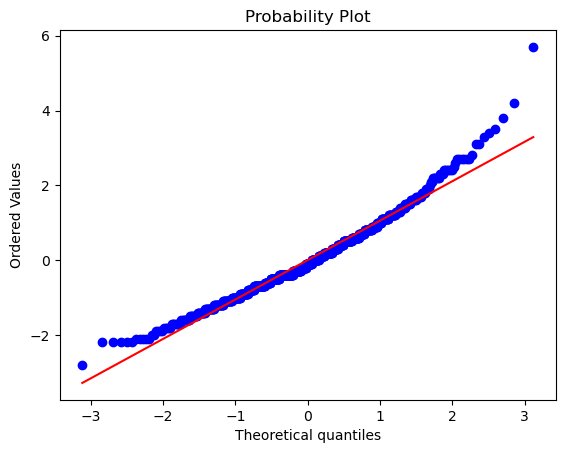

In [48]:
qq_plot = probplot(df['Residuals'], dist='norm', plot=py)
# py.plot(qq_plot[0], qq_plot[0], color='red')
py.show()

In [49]:
df_grouped = df.groupby('xG').describe()['Goals']
df_grouped.head(11)

,count,mean,std,min,25%,50%,75%,max
xG,,,,,,,,
0.0,1.0,0.000000,NaN,0.0,0.0,0.0,0.00,0.0
0.1,6.0,0.500000,0.836660,0.0,0.0,0.0,0.75,2.0
0.2,11.0,0.272727,0.467099,0.0,0.0,0.0,0.50,1.0
0.3,19.0,0.368421,0.495595,0.0,0.0,0.0,1.00,1.0
0.4,31.0,0.258065,0.514311,0.0,0.0,0.0,0.00,2.0
0.5,34.0,0.617647,0.652023,0.0,0.0,1.0,1.00,2.0
0.6,26.0,0.961538,0.870897,0.0,0.0,1.0,1.00,3.0
0.7,32.0,0.406250,0.559918,0.0,0.0,0.0,1.00,2.0
0.8,40.0,1.025000,0.891196,0.0,0.0,1.0,2.00,3.0


In [53]:
fig = px.line(df_grouped, x=df_grouped.index, y='mean',
       labels={
           'x': 'xG', 'mean': 'Average Goals Scored',
       }, 
              title='How xG Correlates with Goals Scored (2023-24)'
       )

fig.add_shape(
    type='line',
    x0=df_grouped.index.min(),
    x1=df_grouped.index.max(),
    y0=df_grouped.index.min(),
    y1=df_grouped.index.max(),
    line=dict(color='black', width=2)
)

# fig.add_trace(px.line(df_grouped, x=df_grouped.index, y='50%', color_discrete_sequence=['red']).data[0])

fig.show()

In [51]:
df_counts.sort_values('count', ascending=False)

,xG,Goals,Residuals,Absolute Residuals,Rounded xG,Rounded Residuals,Absolute Rounded Residuals,count
46,1.4,1,-0.4,0.4,1,0,0,25
8,0.4,0,-0.4,0.4,0,0,0,24
31,1.0,1,0.0,0.0,1,0,0,22
18,0.7,0,-0.7,0.7,1,-1,1,20
26,0.9,1,0.1,0.1,1,0,0,17
...,...,...,...,...,...,...,...,...
114,2.7,6,3.3,3.3,3,3,3,1
115,2.8,0,-2.8,2.8,3,-3,3,1
116,2.8,2,-0.8,0.8,3,-1,1,1
118,2.8,4,1.2,1.2,3,1,1,1
